In [1]:
import awkward as ak
from coffea import processor
from coffea.nanoevents import BaseSchema
import numpy as np
import hist
import matplotlib.pyplot as plt
%matplotlib inline

import infofile # Same infofile used in https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

In [2]:
fileset = {'Data': ['4lep/Data/data_A.4lep.root',
                    '4lep/Data/data_B.4lep.root',
                    '4lep/Data/data_C.4lep.root',
                    '4lep/Data/data_D.4lep.root'],
           'Background $Z,tt^{bar}$': ['4lep/MC/mc_361106.Zee.4lep.root',
                                       '4lep/MC/mc_361107.Zmumu.4lep.root',
                                       '4lep/MC/mc_410000.ttbar_lep.4lep.root'],
           'Background $ZZ^{star}$': ['4lep/MC/mc_363490.llll.4lep.root'],
           'Signal ($m_H$ = 125 GeV)': ['4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_344235.VBFH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_341964.WH125_ZZ4lep.4lep.root',
                                        '4lep/MC/mc_341947.ZH125_ZZ4lep.4lep.root']}

In [3]:
# This needs to exist to properly use get_xsec_weight

sampleNames = {'4lep/MC/mc_361106.Zee.4lep.root': 'Zee',
               '4lep/MC/mc_361107.Zmumu.4lep.root': 'Zmumu',
               '4lep/MC/mc_410000.ttbar_lep.4lep.root': 'ttbar_lep',
               '4lep/MC/mc_363490.llll.4lep.root': 'llll',
               '4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root': 'ggH125_ZZ4lep',
               '4lep/MC/mc_344235.VBFH125_ZZ4lep.4lep.root': 'VBFH125_ZZ4lep',
               '4lep/MC/mc_341964.WH125_ZZ4lep.4lep.root': 'WH125_ZZ4lep',
               '4lep/MC/mc_341947.ZH125_ZZ4lep.4lep.root': 'ZH125_ZZ4lep'}

lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

In [4]:
# Method from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER

In [5]:
# Method from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [6]:
# Adapted from method from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

def calc_mllll(lep_pt,lep_eta,lep_phi,lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[:,0]*np.cos(lep_phi[:,0]) # x-component of lep[0] momentum
    py_0 = lep_pt[:,0]*np.sin(lep_phi[:,0]) # y-component of lep[0] momentum
    pz_0 = lep_pt[:,0]*np.sinh(lep_eta[:,0]) # z-component of lep[0] momentum
    px_1 = lep_pt[:,1]*np.cos(lep_phi[:,1]) # x-component of lep[1] momentum
    py_1 = lep_pt[:,1]*np.sin(lep_phi[:,1]) # y-component of lep[1] momentum
    pz_1 = lep_pt[:,1]*np.sinh(lep_eta[:,1]) # z-component of lep[1] momentum
    px_2 = lep_pt[:,2]*np.cos(lep_phi[:,2]) # x-component of lep[2] momentum
    py_2 = lep_pt[:,2]*np.sin(lep_phi[:,2]) # y-component of lep[2] momentum
    pz_2 = lep_pt[:,2]*np.sinh(lep_eta[:,2]) # z-component of lep[3] momentum
    px_3 = lep_pt[:,3]*np.cos(lep_phi[:,3]) # x-component of lep[3] momentum
    py_3 = lep_pt[:,3]*np.sin(lep_phi[:,3]) # y-component of lep[3] momentum
    pz_3 = lep_pt[:,3]*np.sinh(lep_eta[:,3]) # z-component of lep[3] momentum
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of 4-lepton momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of 4-lepton momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of 4-lepton momentum
    sumE = lep_E[:,0] + lep_E[:,1] + lep_E[:,2] + lep_E[:,3] # energy of 4-lepton system
    return np.sqrt(sumE**2 - sumpx**2 - sumpy**2 - sumpz**2)/1000 #/1000 to go from MeV to GeV

In [7]:
# Adapted from methods from https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata

# cut on lepton charge
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_charge(lep_charge):
# throw away when sum of lepton charges is not equal to 0
# first lepton is [0], 2nd lepton is [1] etc
    return ((lep_charge[:,0] + lep_charge[:,1] + lep_charge[:,2] + lep_charge[:,3]) != 0)

# cut on lepton type
# paper: "selecting two pairs of isolated leptons, each of which is comprised of two leptons with the same flavour and opposite charge"
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
# throw away when none of eeee, mumumumu, eemumu
    sum_lep_type = lep_type[:,0] + lep_type[:,1] + lep_type[:,2] + lep_type[:,3]
    return ((sum_lep_type != 44) & (sum_lep_type != 48) & (sum_lep_type != 52))

In [8]:
class Processor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata['dataset']
        
        # Cut events based on lepton charge
        charge_cut = cut_lep_charge(events.lep_charge)
        events = events[~charge_cut]
        
        # Cut events based on lepton type
        type_cut = cut_lep_type(events.lep_type)
        events = events[~type_cut]
        
        # Calculate the mllll for each event
        mllll = calc_mllll(events.lep_pt, events.lep_eta, events.lep_phi, events.lep_E)
        
        if (dataset != 'Data'):
            # Calculate the event weights
            sample = sampleNames[events.metadata['filename']]
            xsec_weight = get_xsec_weight(sample)
            totalWeights = calc_weight(xsec_weight, events.mcWeight, events.scaleFactor_PILEUP, events.scaleFactor_ELE, events.scaleFactor_MUON, events.scaleFactor_LepTRIGGER)
            
            # Create and fill a histogram for mllll
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat(['Background $Z,tt^{bar}$', 'Background $ZZ^{star}$', 'Signal ($m_H$ = 125 GeV)'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset=dataset, weight=totalWeights)
            )
            output = {
                'entries': {dataset: len(events)},
                'mllll': {'MC': mllllhist}
            }
        else:
            # Create and fill a histogram for mllll
            mllllhist = (
                hist.Hist.new
                .Reg(34, 80, 250, name='mllll', label='4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]')
                .StrCat(['Data'], name='dataset', label='Dataset')
                .Weight()
                .fill(mllll=mllll, dataset=dataset)
            )
            output = {
                'entries': {dataset: len(events)},
                'mllll': {'Data': mllllhist}
            }

        return output

    def postprocess(self, accumulator):
        return accumulator

In [9]:
from dask.distributed import Client
import time

client = Client()

output = processor.run_uproot_job(fileset,
                                treename = 'mini',
                                processor_instance = Processor(),
                                executor = processor.dask_executor,
                                executor_args = {'schema': BaseSchema, 'client': client}
                                )

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

[                                        ] | 0% Completed |  0.8s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


[                                        ] | 0% Completed |  0.9s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


[                                        ] | 0% Completed |  1.0s

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


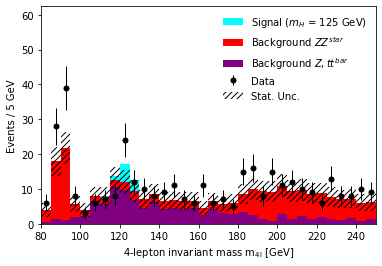

In [10]:
# Plot the histograms
hist.Hist.plot1d(output['mllll']['Data'], histtype='errorbar', color='black')
hist.Hist.plot1d(output['mllll']['MC'], stack=True, histtype='fill', color=['purple', 'red', 'cyan'])

# Basic bin parameters
xmin = 80
xmax = 250
step_size = 5

bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Calculate background statistical uncertainty
mc_x_tot = np.sum(output['mllll']['MC'].values()[:,:2], axis=1)
mc_x_err = np.sqrt(mc_x_tot)

# Plot background statistical uncertainty
plt.bar(bin_centres, # x
        2*mc_x_err, # heights
        alpha=0.5, # half transparency
        bottom=mc_x_tot-mc_x_err, color='none', 
        hatch="////", width=step_size, label='Stat. Unc.')

# Tune plot appearance
main_axes = plt.gca()
main_axes.set_xlim(left=xmin, right=xmax)
main_axes.set_ylim(bottom=0, top=np.amax(output['mllll']['Data'].values())*1.6)
main_axes.set_ylabel('Events / '+str(step_size)+' GeV')
main_axes.legend(frameon=False)

In [11]:
"""
# Just for testing/exploring the events data structure
from coffea.nanoevents import NanoEventsFactory

fname = '4lep/MC/mc_345060.ggH125_ZZ4lep.4lep.root'
events = NanoEventsFactory.from_root(fileset['Data'][0], schemaclass=BaseSchema, treepath='mini').events()
"""
;

''